# Module 4 Brief 2

## Imports
Nous allons importer le dataset digits et les dépendances dont nous aurons besoin.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

%matplotlib inline

## Chargement et Préparation des Données
Nous chargeons le dataset `digits`, le normalisons et le séparons en ensembles d'entraînement et de test.

In [6]:
# Chargement du dataset 8x8
digits = load_digits()
X_small = digits.data  # 1797 images de 64 pixels (8x8)
y_small = digits.target

print(f"Dataset 8x8 - Forme des données : {X_small.shape}")
print(f"Dataset 8x8 - Forme des labels : {y_small.shape}")
print(f"Dataset 8x8 - Valeurs uniques des labels : {np.unique(y_small)}")
# Normalisation des données 8x8
scaler_small = MinMaxScaler()
X_small_normalized = scaler_small.fit_transform(X_small)

# Séparation train/test
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_small_normalized, y_small, test_size=0.2, random_state=42, stratify=y_small
)

print(f"Dataset 8x8 - Train : {X_train_small.shape}, Test : {X_test_small.shape}")

Dataset 8x8 - Forme des données : (1797, 64)
Dataset 8x8 - Forme des labels : (1797,)
Dataset 8x8 - Valeurs uniques des labels : [0 1 2 3 4 5 6 7 8 9]
Dataset 8x8 - Train : (1437, 64), Test : (360, 64)


## Visualisation avec PCA
Nous utilisons l'Analyse en Composantes Principales (PCA) pour réduire la dimensionnalité des données et visualiser les classes en 2D.

Variance expliquée par les 2 composantes : 0.283


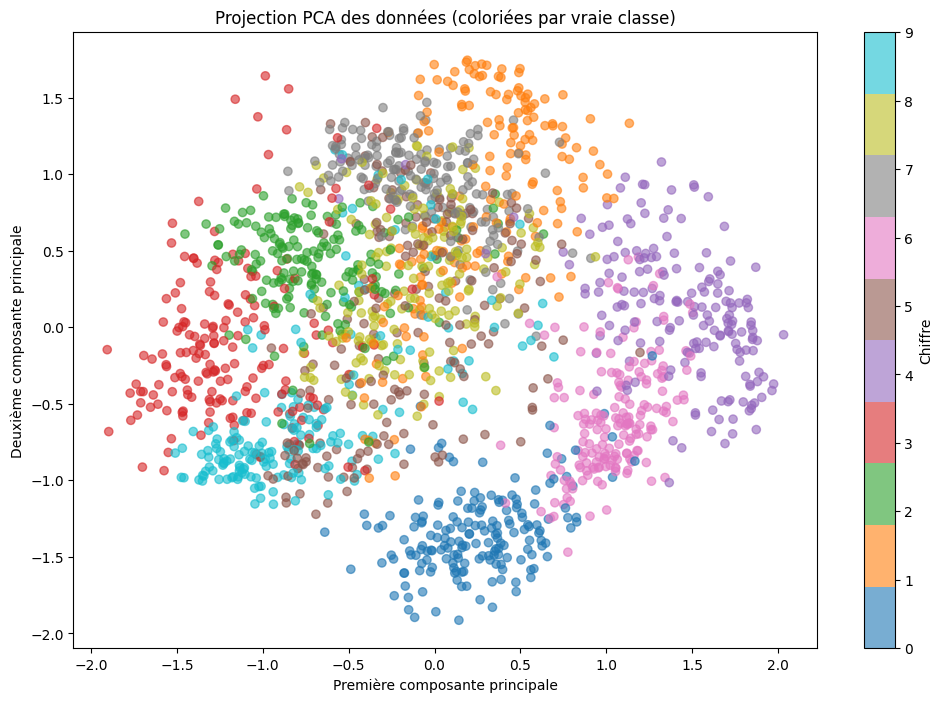

In [7]:
# Application de PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_small_normalized)

print(f"Variance expliquée par les 2 composantes : {pca.explained_variance_ratio_.sum():.3f}")

# Visualisation PCA avec les vraies classes
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_small, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Chiffre')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Projection PCA des données (coloriées par vraie classe)')
plt.show()

## Clustering avec K-Means
Nous allons utiliser l'algorithme K-Means pour regrouper les données en clusters.

### Méthode du Coude
Nous déterminons d'abord le nombre optimal de clusters en utilisant la méthode du coude (Elbow Method).

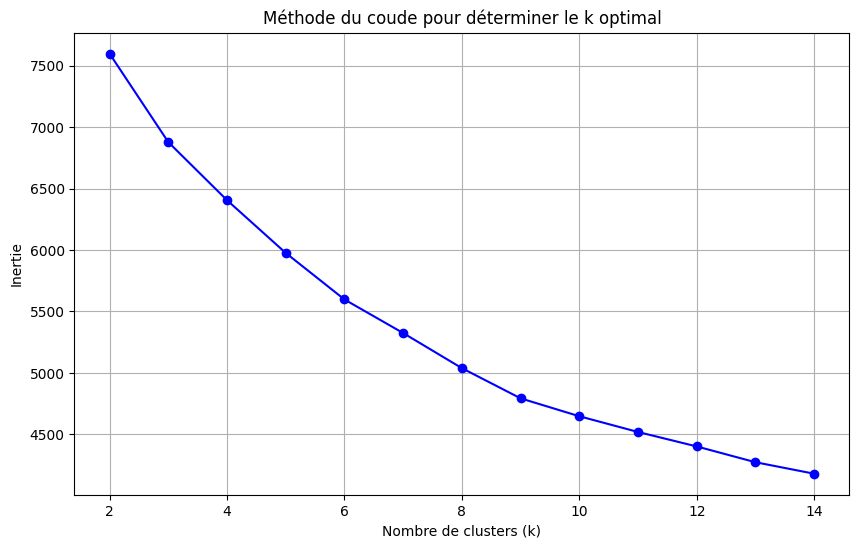

In [8]:
# Détermination du nombre optimal de clusters avec la méthode du coude
inertia = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_small_normalized)
    inertia.append(kmeans.inertia_)

# Courbe du coude
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le k optimal')
plt.grid(True)
plt.show()

### Application de K-Means (k=10)
Comme nous avons 10 chiffres (0-9), nous fixons k=10 et visualisons les clusters obtenus.

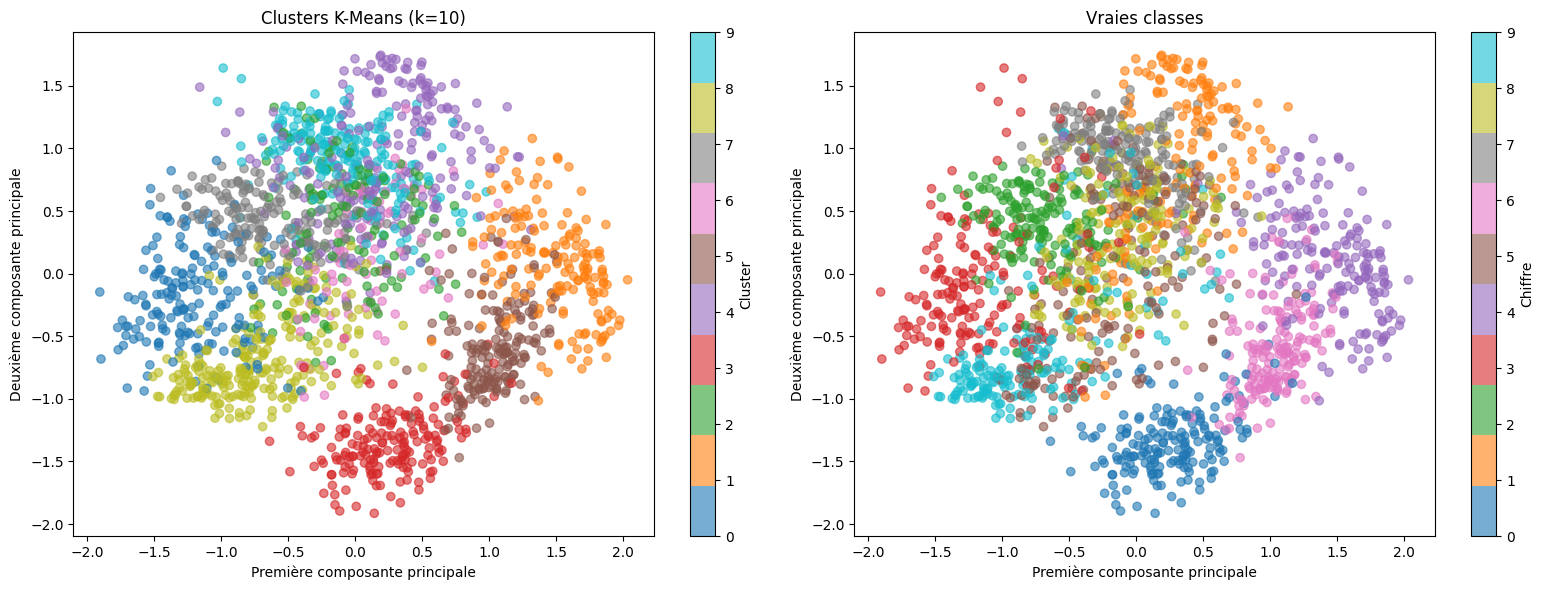

In [9]:
# Application de K-Means avec k=10 (car 10 chiffres)
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_small_normalized)

# Visualisation des clusters K-Means
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Clusters K-Means
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='tab10', alpha=0.6)
axes[0].set_xlabel('Première composante principale')
axes[0].set_ylabel('Deuxième composante principale')
axes[0].set_title('Clusters K-Means (k=10)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Comparaison avec vraies classes
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_small, cmap='tab10', alpha=0.6)
axes[1].set_xlabel('Première composante principale')
axes[1].set_ylabel('Deuxième composante principale')
axes[1].set_title('Vraies classes')
plt.colorbar(scatter2, ax=axes[1], label='Chiffre')

plt.tight_layout()
plt.show()

### Analyse des Clusters
Nous analysons la correspondance entre les clusters trouvés et les vrais chiffres, ainsi que la pureté des clusters.

In [10]:
# Analyse de la correspondance clusters-classes
cluster_to_digit = {}
for cluster in range(10):
    # Trouver le chiffre le plus fréquent dans chaque cluster
    indices = np.where(clusters_kmeans == cluster)[0]
    if len(indices) > 0:
        most_common = np.bincount(y_small[indices]).argmax()
        cluster_to_digit[cluster] = most_common
        print(f"Cluster {cluster} -> Chiffre le plus fréquent : {most_common} ({len(indices)} échantillons)")

# Calcul de la pureté des clusters
def calculate_purity(clusters, labels, n_clusters):
    purity = 0
    total_samples = len(labels)

    for cluster in range(n_clusters):
        indices = np.where(clusters == cluster)[0]
        if len(indices) > 0:
            cluster_labels = labels[indices]
            most_common_count = np.bincount(cluster_labels).max()
            purity += most_common_count

    return purity / total_samples

purity_kmeans = calculate_purity(clusters_kmeans, y_small, 10)
print(f"\nPureté des clusters K-Means : {purity_kmeans:.3f}")

Cluster 0 -> Chiffre le plus fréquent : 3 (186 échantillons)
Cluster 1 -> Chiffre le plus fréquent : 4 (170 échantillons)
Cluster 2 -> Chiffre le plus fréquent : 5 (138 échantillons)
Cluster 3 -> Chiffre le plus fréquent : 0 (179 échantillons)
Cluster 4 -> Chiffre le plus fréquent : 8 (228 échantillons)
Cluster 5 -> Chiffre le plus fréquent : 6 (183 échantillons)
Cluster 6 -> Chiffre le plus fréquent : 1 (85 échantillons)
Cluster 7 -> Chiffre le plus fréquent : 2 (176 échantillons)
Cluster 8 -> Chiffre le plus fréquent : 9 (248 échantillons)
Cluster 9 -> Chiffre le plus fréquent : 7 (204 échantillons)

Pureté des clusters K-Means : 0.791


## Classification avec Régression Logistique
Nous entraînons un modèle de Régression Logistique pour classifier les chiffres et évaluons ses performances.

In [11]:
# Initialisation et entraînement de la régression logistique
log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs'  # Pour les problèmes multi-classes
)

log_reg.fit(X_train_small, y_train_small)

# Prédictions
y_pred_train = log_reg.predict(X_train_small)
y_pred_test = log_reg.predict(X_test_small)

# Évaluation
train_accuracy = accuracy_score(y_train_small, y_pred_train)
test_accuracy = accuracy_score(y_test_small, y_pred_test)

print("=== Performances de la Régression Logistique ===")
print(f"Accuracy sur le train : {train_accuracy:.4f}")
print(f"Accuracy sur le test : {test_accuracy:.4f}")
print(f"F1-score moyen sur le test : {f1_score(y_test_small, y_pred_test, average='weighted'):.4f}")

=== Performances de la Régression Logistique ===
Accuracy sur le train : 0.9875
Accuracy sur le test : 0.9583
F1-score moyen sur le test : 0.9578


### Matrice de Confusion et Rapport
Nous visualisons les erreurs de classification à l'aide d'une matrice de confusion.

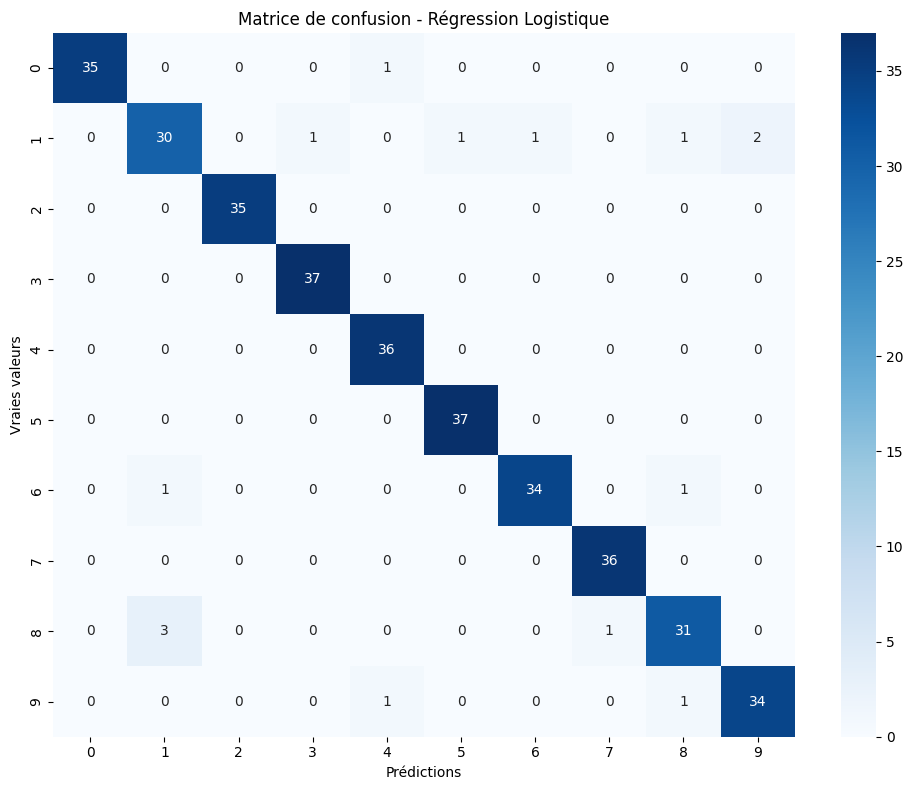


=== Rapport de classification ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.88      0.83      0.86        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.95      1.00      0.97        36
           5       0.97      1.00      0.99        37
           6       0.97      0.94      0.96        36
           7       0.97      1.00      0.99        36
           8       0.91      0.89      0.90        35
           9       0.94      0.94      0.94        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



In [12]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test_small, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion - Régression Logistique')
plt.tight_layout()
plt.show()

# Rapport de classification détaillé
print("\n=== Rapport de classification ===")
print(classification_report(y_test_small, y_pred_test))